# Student Loan Risk with Deep Learning

In [1]:
# Data manipulation and analysis
import pandas as pd
import json
import numpy as np

# Machine learning and neural networks
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

# File path management
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt

# Hyperparameter tuning
import keras_tuner as kt

# Import Custom Utilities
from utilities import highlight_vif, calc_vif, highlight_p_values, calc_p_values, calc_correlation
from utilities import print_title, print_label, print_footer

---

## Prepare the data to be used on a neural network model

### Step 1: Read the `student-loans.csv` file into a Pandas DataFrame. Review the DataFrame, looking for columns that could eventually define your features and target variables.   

In [2]:
# Read the csv into a Pandas DataFrame
file_path = "https://static.bc-edx.com/ai/ail-v-1-0/m18/lms/datasets/student-loans.csv"
loans_df = pd.read_csv(file_path)

# Review the DataFrame
print("Dimensions:", loans_df.ndim)
print("Shape:", loans_df.shape)

loans_df.head()

Dimensions: 2
Shape: (1599, 12)


,payment_history,location_parameter,stem_degree_score,gpa_ranking,alumni_success,study_major_code,time_to_completion,finance_workshop_score,cohort_ranking,total_loan_score,financial_aid_score,credit_ranking
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [3]:
# Review the data types associated with the columns
loans_df.dtypes

payment_history           float64
location_parameter        float64
stem_degree_score         float64
gpa_ranking               float64
alumni_success            float64
study_major_code          float64
time_to_completion        float64
finance_workshop_score    float64
cohort_ranking            float64
total_loan_score          float64
financial_aid_score       float64
credit_ranking              int64
dtype: object

In [4]:
# Inspect for missing values in the DataFrame
loans_df.isnull().sum()

payment_history           0
location_parameter        0
stem_degree_score         0
gpa_ranking               0
alumni_success            0
study_major_code          0
time_to_completion        0
finance_workshop_score    0
cohort_ranking            0
total_loan_score          0
financial_aid_score       0
credit_ranking            0
dtype: int64

In [5]:
# Check the credit_ranking value counts
loans_df["credit_ranking"].value_counts()

credit_ranking
1    855
0    744
Name: count, dtype: int64

### Step 2: Using the preprocessed data, create the features (`X`) and target (`y`) datasets. The target dataset should be defined by the preprocessed DataFrame column “credit_ranking”. The remaining columns should define the features dataset.

In [6]:
# Define the target set y using the credit_ranking column
y = loans_df["credit_ranking"].values

# Display a sample of y
print("Dimensions:", y.ndim)
print("Shape:", y.shape)

y[:5]

Dimensions: 1
Shape: (1599,)


array([0, 0, 0, 1, 0], dtype=int64)

In [7]:
# Define features set X by selecting all columns but credit_ranking
X = loans_df.drop("credit_ranking", axis=1)

# Review the features DataFrame
print("Dimensions:", X.ndim)
print("Shape:", X.shape)

X.head()

Dimensions: 2
Shape: (1599, 11)


,payment_history,location_parameter,stem_degree_score,gpa_ranking,alumni_success,study_major_code,time_to_completion,finance_workshop_score,cohort_ranking,total_loan_score,financial_aid_score
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


### _(Optional): Feature Selection and Multicollinearity Analysis_

In [8]:
# Inspect correlation between features on the X DataFrame
calc_correlation(X)

,payment_history,location_parameter,stem_degree_score,gpa_ranking,alumni_success,study_major_code,time_to_completion,finance_workshop_score,cohort_ranking,total_loan_score,financial_aid_score
payment_history,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668
location_parameter,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288
stem_degree_score,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903
gpa_ranking,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075
alumni_success,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141
study_major_code,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408
time_to_completion,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654
finance_workshop_score,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180
cohort_ranking,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633
total_loan_score,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595


In [9]:
# Inspect the Variance Inflation Factor (VIF) for the features in the X DataFrame
# Benefit: Reducing multicollinearity can improve training stability and convergence on Neural Networks
vif = calc_vif(X)

vif.style.apply(lambda x: highlight_vif(x, threshold=10))

,VIF
gpa_ranking,4.662992
study_major_code,6.442682
time_to_completion,6.519699
alumni_success,6.554877
stem_degree_score,9.183495
location_parameter,17.060026
total_loan_score,21.590621
payment_history,74.452265
financial_aid_score,124.394866
cohort_ranking,1070.967685


**Evaluatation of Features:**
1. High multicollinearity on the following feature: `[location_parameter, total_loan_score, payment_history, financial_aid_score, cohort_ranking, finance_workshop_score]`

2. High correlation on the following features: `['payment_history', 'stem_degree_score', 'finance_workshop_score']`

3. High correlation on the following features: `['study_major_code', 'time_to_completion']`

**Feature Selection Reasoning:**
1. Group `['payment_history', 'stem_degree_score', 'finance_workshop_score']` into a `PCA`
    - These features have strong correlations with each other (over 0.6) and high VIF scores, meaning they contribute heavily to multicollinearity. Applying PCA here will capture the shared variance in a smaller set of components, reducing redundancy.

2. Group `['total_loan_score', 'financial_aid_score', 'cohort_ranking']` into a `PCA`
    - These features have moderate correlations (around 0.2-0.3) with each other and moderate VIFs. Grouping them in PCA can help reduce complexity while retaining their relationship to financial aspects.

3. Leave `[location_parameter, gpa_ranking, alumni_success, study_major_code, time_to_completion]` as is
    - These features don’t show strong correlations with any other features and generally have lower VIFs. Retaining them as individual features can help keep unique information within the model.

In [10]:
# Benefit: Reduces the number of input features, which can lead to faster 
# training and potentially better generalization for the model

# Group 1 PCA
pca_group_1_features = ['payment_history', 'stem_degree_score', 'finance_workshop_score']
pca_group_1_scaler = StandardScaler()
pca_group_1_data = pca_group_1_scaler.fit_transform(X[pca_group_1_features])

# Fit PCA to the scaled data for Group 1
pca_group_1 = PCA(n_components=2)
pca_transformed_1 = pca_group_1.fit_transform(pca_group_1_data)
pca_df_group_1 = pd.DataFrame(pca_transformed_1, columns=[f'pca_group_1_component_{i+1}' for i in range(2)], index=X.index)

# Group 2 PCA
pca_group_2_features = ['study_major_code', 'time_to_completion']
pca_group_2_scaler = StandardScaler()
pca_group_2_data = pca_group_2_scaler.fit_transform(X[pca_group_2_features])

# Fit PCA to the scaled data for Group 2
pca_group_2 = PCA(n_components=2)
pca_transformed_2 = pca_group_2.fit_transform(pca_group_2_data)
pca_df_group_2 = pd.DataFrame(pca_transformed_2, columns=[f'pca_group_2_component_{i+1}' for i in range(2)], index=X.index)

# Group 3 PCA
pca_group_3_features = ['total_loan_score', 'financial_aid_score', 'cohort_ranking', 'alumni_success']
pca_group_3_scaler = StandardScaler()
pca_group_3_data = pca_group_3_scaler.fit_transform(X[pca_group_3_features])

# Fit PCA to the scaled data for Group 3
pca_group_3 = PCA(n_components=4)
pca_transformed_3 = pca_group_3.fit_transform(pca_group_3_data)
pca_df_group_3 = pd.DataFrame(pca_transformed_3, columns=[f'pca_group_3_component_{i+1}' for i in range(4)], index=X.index)

# Combine PCA components with the remaining original features
non_pca_features = [col for col in X.columns if col not in (pca_group_1_features + pca_group_2_features + pca_group_3_features)]
X_transformed = pd.concat([X[non_pca_features], pca_df_group_1, pca_df_group_2, pca_df_group_3], axis=1)

# Review the transformed DataFrame
X_transformed

,location_parameter,gpa_ranking,pca_group_1_component_1,pca_group_1_component_2,pca_group_2_component_1,pca_group_2_component_2,pca_group_3_component_1,pca_group_3_component_2,pca_group_3_component_3,pca_group_3_component_4
0,0.700,1.9,-0.792216,-1.377956,-0.597735,0.061561,-0.800056,-0.870383,1.204512,-0.359223
1,0.880,2.6,-0.934462,-1.001043,1.058540,-0.175557,0.765056,-0.487018,-0.294722,-0.132885
2,0.760,2.3,-0.764596,-0.931612,0.102797,0.221124,0.396394,-0.532441,-0.048406,-0.142385
3,0.280,1.9,2.225740,0.578786,0.367054,0.214896,0.308602,-0.929671,-0.788215,-0.051913
4,0.700,1.9,-0.792216,-1.377956,-0.597735,0.061561,-0.800056,-0.870383,1.204512,-0.359223
...,...,...,...,...,...,...,...,...,...,...
1594,0.600,2.0,-1.843771,0.000390,1.037333,-1.143460,-0.683913,-0.055606,0.700173,0.263697
1595,0.550,2.2,-1.833956,-0.010557,1.661198,-1.466291,-0.984727,1.136441,0.700132,-0.516352
1596,0.510,2.3,-1.424597,-0.134624,0.748460,-1.026606,-0.429623,0.858473,0.353294,-0.312951
1597,0.645,2.0,-1.676880,-0.069899,1.037333,-1.143460,-0.825482,0.315589,1.363547,-0.617280


In [11]:
# Calculate cumulative explained variance for each PCA group
cumulative_variance_group_1 = np.cumsum(pca_group_1.explained_variance_ratio_)
cumulative_variance_group_2 = np.cumsum(pca_group_2.explained_variance_ratio_)
cumulative_variance_group_3 = np.cumsum(pca_group_3.explained_variance_ratio_)

print_title("Cumulative Explained Variance for PCA Groups")
print_label("Group 1", f"{cumulative_variance_group_1}")
print_label("Group 2", f"{cumulative_variance_group_2}")
print_label("Group 3", f"{cumulative_variance_group_3}", closed_corners=True)

# Decide on the number of components to retain based on cumulative explained variance
n_components_group_1 = np.argmax(cumulative_variance_group_1 >= 0.90) + 1
n_components_group_2 = np.argmax(cumulative_variance_group_2 >= 0.90) + 1
n_components_group_3 = np.argmax(cumulative_variance_group_3 >= 0.90) + 1

print_title("Number of Components to Retain for PCA Groups")
print_label("Group 1", n_components_group_1)
print_label("Group 2", n_components_group_2)
print_label("Group 3", n_components_group_3, closed_corners=True)

╔═══════════════════════════════════════════════════════════════╗
║         Cumulative Explained Variance for PCA Groups          ║
╠═══════════════════════════════════════════════════════════════╣
║ Group 1                        |   [0.71574526 0.92743211]    ║
║ Group 2                        |   [0.83383323 1.        ]    ║
║ Group 3                        | [0.40630628 0.68198184 0.87003255 1.        ] ║
╚═══════════════════════════════════════════════════════════════╝
╔═══════════════════════════════════════════════════════════════╗
║         Number of Components to Retain for PCA Groups         ║
╠═══════════════════════════════════════════════════════════════╣
║ Group 1                        |              2               ║
║ Group 2                        |              2               ║
║ Group 3                        |              4               ║
╚═══════════════════════════════════════════════════════════════╝


In [12]:
# Display the explained variance ratios for the PCA components
print_title("PCA Explained Variance Ratios")
print_label("pca_group_1_component_1:", pca_group_1.explained_variance_ratio_[0])
print_label("pca_group_1_component_2:", pca_group_1.explained_variance_ratio_[1])
print_label("pca_group_2_component_1:", pca_group_2.explained_variance_ratio_[0])
print_label("pca_group_2_component_2:", pca_group_2.explained_variance_ratio_[1])
print_label("pca_group_3_component_1:", pca_group_3.explained_variance_ratio_[0])
print_label("pca_group_3_component_2:", pca_group_3.explained_variance_ratio_[1])
print_label("pca_group_3_component_3:", pca_group_3.explained_variance_ratio_[2])
print_label("pca_group_3_component_4:", pca_group_3.explained_variance_ratio_[3], closed_corners=True)

╔═══════════════════════════════════════════════════════════════╗
║                 PCA Explained Variance Ratios                 ║
╠═══════════════════════════════════════════════════════════════╣
║ pca_group_1_component_1:       |           0.71575            ║
║ pca_group_1_component_2:       |           0.21169            ║
║ pca_group_2_component_1:       |           0.83383            ║
║ pca_group_2_component_2:       |           0.16617            ║
║ pca_group_3_component_1:       |           0.40631            ║
║ pca_group_3_component_2:       |           0.27568            ║
║ pca_group_3_component_3:       |           0.18805            ║
║ pca_group_3_component_4:       |           0.12997            ║
╚═══════════════════════════════════════════════════════════════╝


In [13]:
# Create DataFrames for the PCA weights

# Group 1 PCA weights
pca_group_1_weights = pd.DataFrame(
    data=pca_group_1.components_.T,
    columns=[f"pca_group_1_component_{i+1}" for i in range(pca_group_1.n_components_)],
    index=pca_group_1_features
)

# Group 2 PCA weights
pca_group_2_weights = pd.DataFrame(
    data=pca_group_2.components_.T,
    columns=[f"pca_group_2_component_{i+1}" for i in range(pca_group_2.n_components_)],
    index=pca_group_2_features
)

# Group 3 PCA weights
pca_group_3_weights = pd.DataFrame(
    data=pca_group_3.components_.T,
    columns=[f"pca_group_3_component_{i+1}" for i in range(pca_group_3.n_components_)],
    index=pca_group_3_features
)

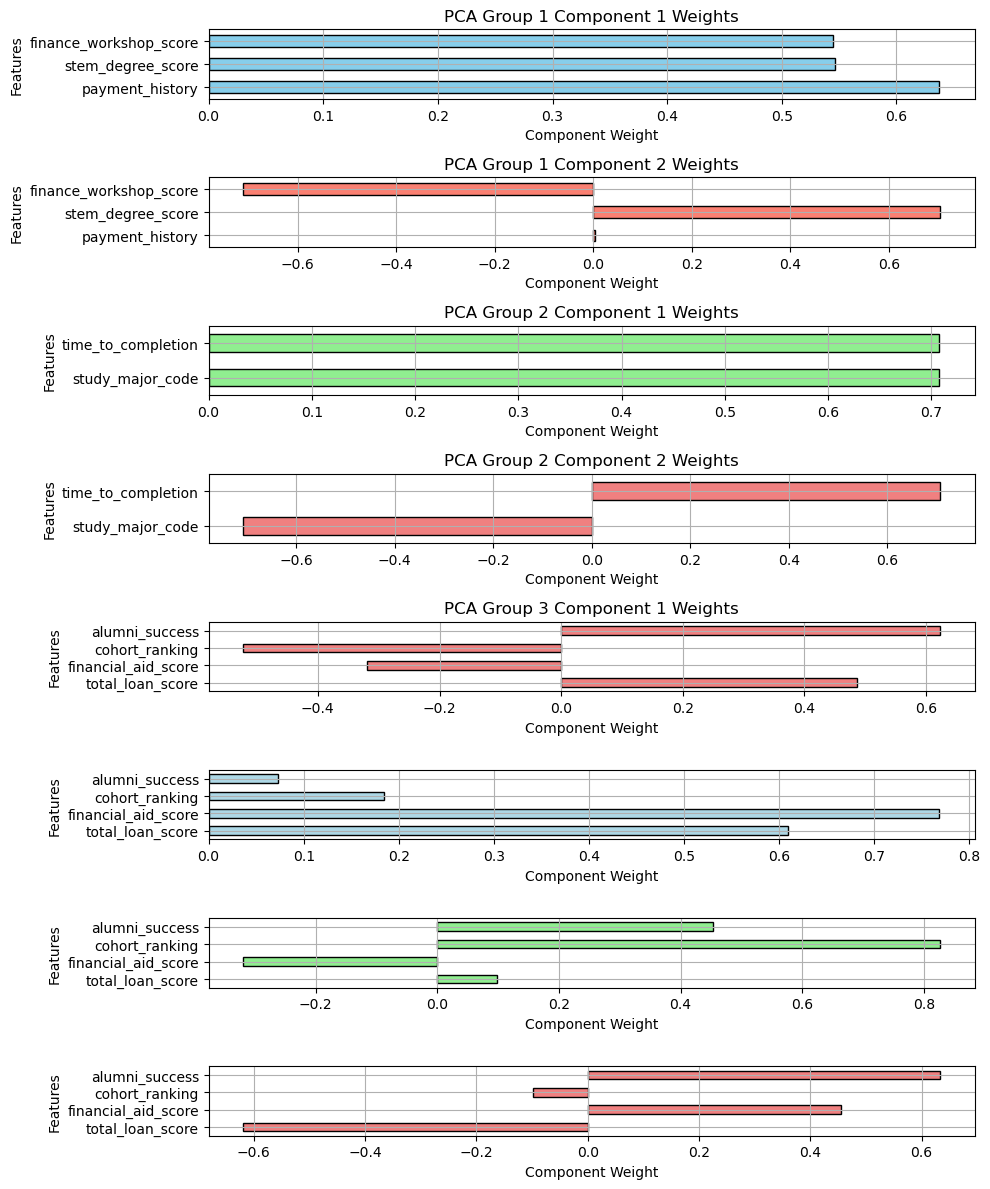

In [14]:
# Display the PCA weights as horizontal bar plots for each component
# This will help us understand the relationship between the original features and the PCA components
fig, axes = plt.subplots(8, 1, figsize=(10, 12))

# Plot the first component of Group 1 as a horizontal bar plot
pca_group_1_weights['pca_group_1_component_1'].plot(
    kind='barh',
    ax=axes[0],
    edgecolor='black',
    color="skyblue",
    legend=False,
    grid=True,
    title="PCA Group 1 Component 1 Weights",
    xlabel="Component Weight",
    ylabel="Features"
)

# Plot the second component of Group 1 as a horizontal bar plot
pca_group_1_weights['pca_group_1_component_2'].plot(
    kind='barh',
    ax=axes[1],
    edgecolor='black',
    color="salmon",
    legend=False,
    grid=True,
    title="PCA Group 1 Component 2 Weights",
    xlabel="Component Weight",
    ylabel="Features"
)

# Plot the first component of Group 2 as a horizontal bar plot
pca_group_2_weights['pca_group_2_component_1'].plot(
    kind='barh',
    ax=axes[2],
    edgecolor='black',
    color="lightgreen",
    legend=False,
    grid=True,
    title="PCA Group 2 Component 1 Weights",
    xlabel="Component Weight",
    ylabel="Features"
)

# Plot the second component of Group 2 as a horizontal bar plot
pca_group_2_weights['pca_group_2_component_2'].plot(
    kind='barh',
    ax=axes[3],
    edgecolor='black',
    color="lightcoral",
    legend=False,
    grid=True,
    title="PCA Group 2 Component 2 Weights",
    xlabel="Component Weight",
    ylabel="Features"
)

# Plot the first component of Group 3 as a horizontal bar plot
pca_group_3_weights['pca_group_3_component_1'].plot(
    kind='barh',
    ax=axes[4],
    edgecolor='black',
    color="lightcoral",
    legend=False,
    grid=True,
    title="PCA Group 3 Component 1 Weights",
    xlabel="Component Weight",
    ylabel="Features"
)

# Plot the second component of Group 3 as a horizontal bar plot
pca_group_3_weights['pca_group_3_component_2'].plot(
    kind='barh',
    ax=axes[5],
    edgecolor='black',
    color="lightblue",
    legend=False,
    grid=True,
    xlabel="Component Weight",
    ylabel="Features"
)

# Plot the third component of Group 3 as a horizontal bar plot
pca_group_3_weights['pca_group_3_component_3'].plot(
    kind='barh',
    ax=axes[6],
    edgecolor='black',
    color="lightgreen",
    legend=False,
    grid=True,
    xlabel="Component Weight",
    ylabel="Features"
)

# Plot the fourth component of Group 3 as a horizontal bar plot
pca_group_3_weights['pca_group_3_component_4'].plot(
    kind='barh',
    ax=axes[7],
    edgecolor='black',
    color="lightcoral",
    legend=False,
    grid=True,
    xlabel="Component Weight",
    ylabel="Features"
)

plt.tight_layout()
plt.show()

In [15]:
# Re-inspect the correlation between features on the X DataFrame after PCA transformation
calc_correlation(X_transformed)

,location_parameter,gpa_ranking,pca_group_1_component_1,pca_group_1_component_2,pca_group_2_component_1,pca_group_2_component_2,pca_group_3_component_1,pca_group_3_component_2,pca_group_3_component_3,pca_group_3_component_4
location_parameter,1.000000,0.001918,-0.308979,-0.508910,0.036120,0.106681,-0.115210,-0.253850,0.300875,0.118202
gpa_ranking,0.001918,1.000000,0.235383,-0.189135,0.213590,0.019599,0.053846,0.022783,-0.067455,0.082313
pca_group_1_component_1,-0.308979,0.235383,1.000000,-0.000000,-0.058678,0.108239,0.488337,-0.075367,-0.405617,-0.069490
pca_group_1_component_2,-0.508910,-0.189135,-0.000000,1.000000,-0.036920,0.002973,-0.006267,0.447147,-0.349722,0.241115
pca_group_2_component_1,0.036120,0.213590,-0.058678,-0.036920,1.000000,-0.000000,0.070811,-0.077727,0.078398,-0.114188
pca_group_2_component_2,0.106681,0.019599,0.108239,0.002973,-0.000000,1.000000,0.131659,-0.154341,-0.073005,-0.028172
pca_group_3_component_1,-0.115210,0.053846,0.488337,-0.006267,0.070811,0.131659,1.000000,0.000000,0.000000,0.000000
pca_group_3_component_2,-0.253850,0.022783,-0.075367,0.447147,-0.077727,-0.154341,0.000000,1.000000,-0.000000,0.000000
pca_group_3_component_3,0.300875,-0.067455,-0.405617,-0.349722,0.078398,-0.073005,0.000000,-0.000000,1.000000,0.000000
pca_group_3_component_4,0.118202,0.082313,-0.069490,0.241115,-0.114188,-0.028172,0.000000,0.000000,0.000000,1.000000


In [16]:
# Re-inspect the Variance Inflation Factor (VIF) for the features in the X DataFrame after PCA transformation
# Ensure multicollinearity is addressed and that the VIF values are below the threshold of 10
vif = calc_vif(X_transformed)

vif.style.apply(lambda x: highlight_vif(x, threshold=10))

,VIF
pca_group_2_component_2,1.059632
pca_group_2_component_1,1.112348
pca_group_3_component_4,1.133069
pca_group_3_component_2,1.432683
pca_group_3_component_1,1.465360
pca_group_3_component_3,1.569752
pca_group_1_component_2,1.701350
pca_group_1_component_1,1.994861
location_parameter,4.028728
gpa_ranking,4.067471


### Step 3: Split the features and target sets into training and testing datasets.


In [17]:
# Split the preprocessed data into a training and testing dataset
# Assign the function a random_state equal to 1
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, random_state=1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape, end=f"\n\n")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1199, 10)
y_train shape: (1199,)

X_test shape: (400, 10)
y_test shape: (400,)


In [18]:
# Inspect the p-values of the features in the training dataset to identify insignificant features
# Benefit: Helps in identifying and removing irrelevant or redundant features, 
# which can simplify the model and potentially improve performance.
p_values, ols_model = calc_p_values(X_train, y_train)

p_values.style.apply(highlight_p_values)

,p_value
location_parameter,0.000000
pca_group_3_component_2,0.000000
gpa_ranking,0.000000
pca_group_2_component_2,0.000000
pca_group_1_component_2,0.000000
pca_group_2_component_1,0.000000
pca_group_3_component_4,0.000039
pca_group_3_component_3,0.000276
pca_group_3_component_1,0.087038
pca_group_1_component_1,0.198380


### Step 4: Use scikit-learn's `StandardScaler` to scale the features data.

In [19]:
# Create a StandardScaler instance
X_scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler.fit(X_train)

# Transform the training and testing data using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)


X_train_scaled shape: (1199, 10)
X_test_scaled shape: (400, 10)


---

## Compile and Evaluate a Model Using a Neural Network

### _(Optional): Create a method that will assist in finding the most optimal hyperparameters using `keras_tuner`_

In [20]:
def create_model(hp):
    # Define the the number of inputs (features) to the model
    input_nodes = X_train_scaled.shape[1]

    # Define the min and max number of recommended hidden nodes for each layer
    rec_hidden_nodes_min = round(input_nodes * 2)
    rec_hidden_nodes_max = round(input_nodes * 3.5)

    # Define the number of hidden nodes for the first hidden layer
    hidden_nodes_layer_1 = hp.Int("units_layer_1", min_value=rec_hidden_nodes_min, max_value=rec_hidden_nodes_max, step=2)

    # Define the number of neurons in the output layer
    output_neurons = 1

    # Create the Sequential model instance
    nn_model = Sequential()

    # Choose the activation function for the hidden layers
    activation = hp.Fixed("activation", value="relu")

    # Define the number of additional hidden layers
    additional_layers = hp.Int("additional_layers", min_value=1, max_value=3)

    # Input Layer
    nn_model.add(Input(shape=(input_nodes,)))

    # Hidden Layer 1: Add the first hidden layer
    nn_model.add(Dense(units=hidden_nodes_layer_1, activation=activation, name='hidden_layer_1'))
    
    # Hidden layers 2 through n: Add the second hidden layer through the n-th hidden layer
    for i in range(additional_layers):
        layer_num = i + 2

        # Define the number of hidden nodes for the second hidden layer through the n-th hidden layer
        hidden_nodes_layer_n = hp.Int(f"units_layer_{layer_num}", min_value=rec_hidden_nodes_min, max_value=rec_hidden_nodes_max, step=2)

        nn_model.add(Dense(units=hidden_nodes_layer_n, activation=activation, name=f'hidden_layer_{layer_num}'))

    # Add the output layer to the model specifying the number of output neurons and activation function
    nn_model.add(Dense(units=output_neurons, activation="sigmoid", name='output_layer'))

    # Compile the Sequential model
    nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return nn_model

In [21]:
# Instantiate the Keras Tuner Hyperband tuner
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",                # Optimize model based on the validation accuracy
    max_epochs=50,                           # Max number of epochs to train the model
    hyperband_iterations=2,                  # Number of times to halve and retrain the model
    directory='keras_tuner_student_loans',   # Directory to store the results
)

Reloading Tuner from keras_tuner_student_loans\untitled_project\tuner0.json


In [22]:
# Search for the best hyperparameters
tuner.search(
    X_train_scaled,
    y_train,
    epochs=50, # Max number of epochs that a model can be trained for
    validation_data=(X_test_scaled, y_test),
)

In [23]:
# View the summary of the search for the best hyperparameters
# This will display the best epoch, the best hyperparameters, and the best validation accuracy
tuner.results_summary()

Results summary
Results in keras_tuner_student_loans\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0089 summary
Hyperparameters:
units_layer_1: 20
activation: relu
additional_layers: 3
units_layer_2: 20
units_layer_3: 30
units_layer_4: 24
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7724999785423279

Trial 0163 summary
Hyperparameters:
units_layer_1: 32
activation: relu
additional_layers: 2
units_layer_2: 30
units_layer_3: 26
units_layer_4: 34
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0157
Score: 0.7699999809265137

Trial 0141 summary
Hyperparameters:
units_layer_1: 30
activation: relu
additional_layers: 3
units_layer_2: 32
units_layer_3: 22
units_layer_4: 22
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0138
Score: 0.7699999809265137

Trial 0084 summary
Hyperparameters:
units_layer_1: 32
activation: relu
addition

### Step 1: Create a deep neural network by assigning the number of input features, the number of layers, and the number of neurons on each layer using Tensorflow’s Keras.

> **Hint** You can start with a two-layer deep neural network model that uses the `relu` activation function for both layers.


In [24]:
# Retrieve the best hyperparameters from the search
best_params = tuner.get_best_hyperparameters()[0].values

# Display the best hyperparameters from the search
print(json.dumps(best_params, indent=4))

{
    "units_layer_1": 20,
    "activation": "relu",
    "additional_layers": 3,
    "units_layer_2": 20,
    "units_layer_3": 30,
    "units_layer_4": 24,
    "tuner/epochs": 30,
    "tuner/initial_epoch": 0,
    "tuner/bracket": 0,
    "tuner/round": 0
}


In [25]:
# Define the the number of inputs (features) to the model
input_nodes = X_train_scaled.shape[1]

# Review the number of features
input_nodes

10

In [26]:
# Define the number of neurons in the output layer
output_neurons = 1

In [27]:
# View the number of hidden nodes for the first hidden layer the n-th hidden layer found by the tuner
for i in range(best_params['additional_layers'] + 1):
    layer_num = i + 1
    print(f"Hidden Layer {layer_num} Nodes: {best_params[f'units_layer_{layer_num}']}")

Hidden Layer 1 Nodes: 20
Hidden Layer 2 Nodes: 20
Hidden Layer 3 Nodes: 30
Hidden Layer 4 Nodes: 24


In [28]:
# Create a new Sequential model using best hyperparameters found by the tuner search
nn_model = Sequential()

# Input layer
nn_model.add(Input(shape=(input_nodes,)))

# Add the first hidden layer through the n-th hidden layer using the best hyperparameters found by the tuner search
for i in range(best_params["additional_layers"] + 1):
    nn_model.add(
        Dense(
            units=best_params[f"units_layer_{i+1}"],
            activation=best_params["activation"],
            name=f'hidden_layer_{i+1}'
        )
    )

# Add the output layer to the model specifying the number of output neurons and activation function
nn_model.add(Dense(units=output_neurons, activation="sigmoid", name='output_layer'))

In [29]:
# Display the Sequential model summary
print(nn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 30)             │           630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_4 (Dense)          │ (None, 24)             │           744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,039 (7.96 KB)

 Trainable params: 2,039 (7.96 KB)

 Non-trainable params: 0 (0.00 B)

None


### Step 2: Compile and fit the model using the `binary_crossentropy` loss function, the `adam` optimizer, and the `accuracy` evaluation metric.


In [30]:
# Compile the Sequential model
nn_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [31]:
# Fit the model using optimal epochs obtained from the tuner
fit_model = nn_model.fit(
    X_train_scaled,
    y_train,
    epochs=best_params["tuner/epochs"],
    validation_data=(X_test_scaled, y_test),
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5541 - loss: 0.6820 - val_accuracy: 0.6475 - val_loss: 0.6309
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6580 - loss: 0.6246 - val_accuracy: 0.6925 - val_loss: 0.5763
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6908 - loss: 0.5631 - val_accuracy: 0.7325 - val_loss: 0.5517
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7234 - loss: 0.5389 - val_accuracy: 0.7325 - val_loss: 0.5410
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7676 - loss: 0.4937 - val_accuracy: 0.7375 - val_loss: 0.5361
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7602 - loss: 0.5065 - val_accuracy: 0.7375 - val_loss: 0.5292
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7677 - loss: 0.5039 - val_accuracy: 0.7425 - val_loss: 0.5266
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7674 - loss: 0.4950 - val_accuracy: 0.7475 - val_loss:

### Step 3: Evaluate the model using the test data to determine the model’s loss and accuracy.


In [34]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data

# This will evaluate the Best Model found by Keras Tuner
model_loss, model_accuracy = tuner.get_best_models()[0].evaluate(
    X_test_scaled,
    y_test,
    verbose=2
)

# Display the model loss and accuracy results
print_title("Model Results (Keras Tuner)")
print_label("Accuracy:", model_accuracy)
print_label("Loss:", model_loss, closed_corners=True)

13/13 - 0s - 21ms/step - accuracy: 0.7725 - loss: 0.5168
╔═══════════════════════════════════════════════════════════════╗
║                  Model Results (Keras Tuner)                  ║
╠═══════════════════════════════════════════════════════════════╣
║ Accuracy:                      |           0.77250            ║
║ Loss:                          |           0.51682            ║
╚═══════════════════════════════════════════════════════════════╝


In [35]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data

# This will evaluate the model we recreated from scratch and used the best hyperparameters found by the tuner
model_loss, model_accuracy = nn_model.evaluate(
    X_test_scaled,
    y_test,
    verbose=2
)

# Display the model loss and accuracy results
print_title("Model Results (Recreated Model)")
print_label("Accuracy:", model_accuracy)
print_label("Loss:", model_loss, closed_corners=True)

13/13 - 0s - 4ms/step - accuracy: 0.7125 - loss: 0.5642
╔═══════════════════════════════════════════════════════════════╗
║                Model Results (Recreated Model)                ║
╠═══════════════════════════════════════════════════════════════╣
║ Accuracy:                      |           0.71250            ║
║ Loss:                          |           0.56422            ║
╚═══════════════════════════════════════════════════════════════╝


<Axes: title={'center': 'Loss Over Epochs'}, xlabel='Epoch', ylabel='Loss'>

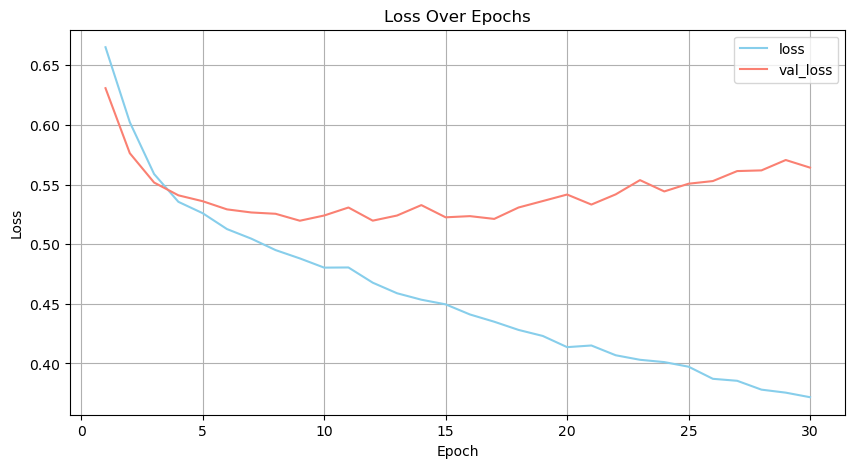

In [36]:
# Create a DataFrame using the model history to plot the Loss and Accuracy over epochs
history_df = pd.DataFrame(fit_model.history)

history_df.index += 1

# Plot the Loss over epochs
history_df.plot(
    y=["loss", "val_loss"],
    title="Loss Over Epochs",
    xlabel="Epoch",
    ylabel="Loss",
    legend=True,
    figsize=(10, 5),
    grid=True,
    style=['skyblue', 'salmon']
)

<Axes: title={'center': 'Accuracy Over Epochs'}, xlabel='Epoch', ylabel='Accuracy'>

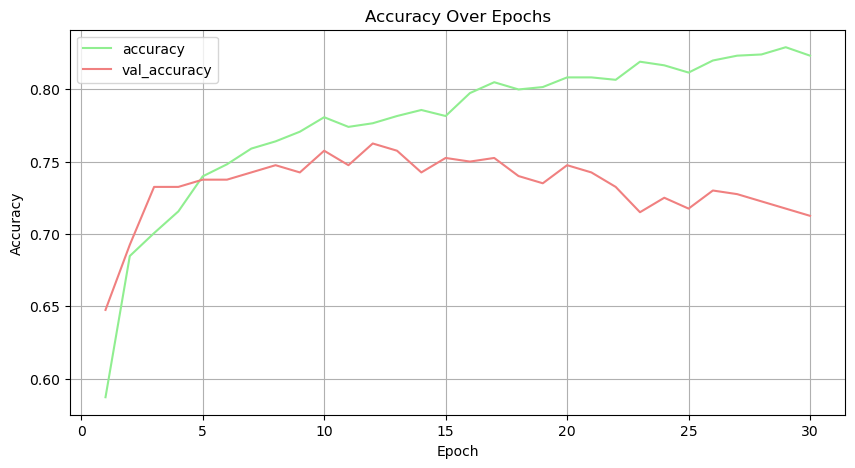

In [37]:
# Plot the Accuracy over epochs
history_df.plot(
    y=["accuracy", "val_accuracy"],
    title="Accuracy Over Epochs",
    xlabel="Epoch",
    ylabel="Accuracy",
    legend=True,
    figsize=(10, 5),
    grid=True,
    style=['lightgreen', 'lightcoral']
)

### Step 4: Save and export your model to a keras file, and name the file `student_loans.keras`.


In [39]:
# Set the model's file path
file_name = "student_loans.keras"
file_path = Path(f"models/{file_name}")

# Export your model to a keras file
# Note: Save the tuner model instead of the recreated model due to better scores
kt_best_model = tuner.get_best_models()[0]
kt_best_model.save(file_path)

# nn_model.save(file_path)

---
## Predict Loan Repayment Success by Using your Neural Network Model

### Step 1: Reload your saved model.

In [41]:
# Set the model's file path
file_name = "student_loans.keras"
file_path = Path(f"models/{file_name}")

# Load the model to a new object
loaded_model = tf.keras.models.load_model(file_path)

### Step 2: Make predictions on the testing data and save the predictions to a DataFrame.

In [42]:
# Make predictions with the test data
y_predict = loaded_model.predict(X_test_scaled)

# Display a sample of the predictions
print("Shape:", y_predict.shape)
y_predict[:5]


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Shape: (400, 1)


array([[0.16811365],
       [0.39603058],
       [0.85838675],
       [0.7484349 ],
       [0.9790695 ]], dtype=float32)

In [43]:
# Save the predictions to a DataFrame and round the predictions to binary results
predictions_df = pd.DataFrame(
    data=y_predict,
    columns=["predictions"],
)

predictions_df["predictions"] = round(predictions_df["predictions"], 0).astype(int)

predictions_df

,predictions
0,0
1,0
2,1
3,1
4,1
...,...
395,1
396,0
397,1
398,0


### Step 4: Display a classification report with the y test data and predictions

In [44]:
# Print the classification report with the y test data and predictions
print(classification_report(y_test, predictions_df["predictions"]))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76       188
           1       0.80      0.76      0.78       212

    accuracy                           0.77       400
   macro avg       0.77      0.77      0.77       400
weighted avg       0.77      0.77      0.77       400



- **Default (`0`):** The model predicts that the student will default (high risk of not repaying) their loan
- **Repay (`1`):** The model predicts that the student will repay (low risk of not repaying) their loan

In [45]:
# Create a confusion matrix to evaluate the model's performance
confusion_test = confusion_matrix(y_test, predictions_df["predictions"])

# Create a DataFrame to display the confusion matrix
confusion_df = pd.DataFrame(
    confusion_test,
    index=["Actual Default", "Actual Repay"],
    columns=["Predicted Default", "Predicted Repay"]
)

# Name the confusion matrix
confusion_df.name = "Loan Repayment Prediction Confusion Matrix"

# Style the confusion matrix for readability
styled_confusion_df = (confusion_df.style
                       .set_caption(confusion_df.name)
                       .set_properties(**{'text-align': 'center'})
                       .background_gradient(cmap='Greens'))


# Display the confusion matrix
styled_confusion_df

,Predicted Default,Predicted Repay
Actual Default,148,40
Actual Repay,51,161


---
## Discuss creating a recommendation system for student loans

Briefly answer the following questions in the space provided:

1. Describe the data that you would need to collect to build a recommendation system to recommend student loan options for students. Explain why this data would be relevant and appropriate.

2. Based on the data you chose to use in this recommendation system, would your model be using collaborative filtering, content-based filtering, or context-based filtering? Justify why the data you selected would be suitable for your choice of filtering method.

3. Describe two real-world challenges that you would take into consideration while building a recommendation system for student loans. Explain why these challenges would be of concern for a student loan recommendation system.

**1. Describe the data that you would need to collect to build a recommendation system to recommend student loan options for students. Explain why this data would be relevant and appropriate.**


**2. Based on the data you chose to use in this recommendation system, would your model be using collaborative filtering, content-based filtering, or context-based filtering? Justify why the data you selected would be suitable for your choice of filtering method.**


**3. Describe two real-world challenges that you would take into consideration while building a recommendation system for student loans. Explain why these challenges would be of concern for a student loan recommendation system.**

